In [1]:
import torch, time
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from torchvision.utils import make_grid

In [2]:
np.set_printoptions(formatter=dict(int=lambda x: f"{x:4}")) # Custom Print Formatting

In [3]:
# MNIST Image Data -> Tensors
transform = transforms.ToTensor()

In [4]:
mnist_train = datasets.MNIST(root="../PYTORCH_NOTEBOOKS/Data/",train=True,download=True,transform=transform)

In [5]:
mnist_test = datasets.MNIST(root="../PYTORCH_NOTEBOOKS/Data/",train=False,download=True,transform=transform)

In [6]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../PYTORCH_NOTEBOOKS/Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../PYTORCH_NOTEBOOKS/Data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
type(mnist_train)

torchvision.datasets.mnist.MNIST

In [9]:
img, label = mnist_train[0]
img.shape

torch.Size([1, 28, 28])

In [10]:
label

5

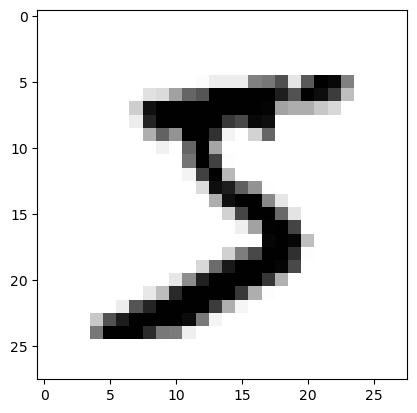

In [11]:
plt.imshow(img.reshape(28,28),cmap='gist_yarg');

In [12]:
torch.manual_seed(101)

# 0 images, 1 images, .... -> Random shuffling
train_loader = DataLoader(dataset=mnist_train,batch_size=100,shuffle=True) # Generalize to all types of images of all digits 0-9
test_loader = DataLoader(dataset=mnist_test,batch_size=500,shuffle=False) # No weights and biases adjustment so no need of shuffling

In [13]:
for img, label in train_loader:
    break

In [14]:
img.shape

torch.Size([100, 1, 28, 28])

In [15]:
label

tensor([7, 2, 3, 5, 8, 5, 3, 6, 9, 9, 1, 3, 5, 5, 4, 5, 4, 1, 0, 4, 5, 4, 5, 4,
        0, 5, 8, 2, 2, 3, 3, 7, 2, 8, 1, 2, 3, 1, 7, 9, 0, 4, 9, 1, 7, 9, 7, 2,
        6, 5, 5, 8, 5, 0, 4, 0, 0, 4, 9, 2, 6, 0, 8, 4, 1, 8, 5, 2, 0, 3, 3, 4,
        6, 1, 5, 3, 5, 9, 0, 7, 4, 5, 3, 6, 6, 4, 5, 3, 9, 7, 1, 7, 6, 7, 9, 3,
        5, 9, 9, 6])

In [16]:
label.shape

torch.Size([100])

In [17]:
# Print the first 16 images
print("Labels:",label[:16].numpy())

Labels: [   7    2    3    5    8    5    3    6    9    9    1    3    5    5
    4    5]


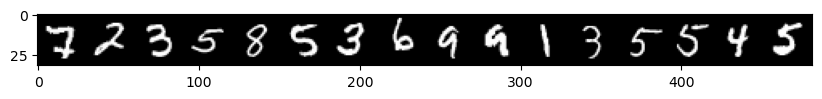

In [18]:
# Print the first 16 images
images = make_grid(img[:16],nrow=16) # default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH(Color, Width, Height) to HWC
plt.imshow(np.transpose(images.numpy(), (1,2,0)));

In [19]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self,input_size=784,output_size=10,layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(input_size,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],output_size)

    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1) # Multi class classification

In [20]:
torch.manual_seed(101)

model = MultiLayerPerceptron()
model

MultiLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [22]:
# 105,214 parameters being adjusted by the network -> A limitation of ANN while dealing with image data
# This is a motivation behind the utility of CNN

In [23]:
criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [24]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [25]:
img.shape # [100,1,28,28] -> [100,784] flatten the image into 784 pixels

torch.Size([100, 1, 28, 28])

In [26]:
img.view(100,-1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [27]:
img.view(100,-1).shape

torch.Size([100, 784])

In [28]:
start_time = time.time()

epochs = 10

# Trackers
train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(epochs):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred,y_train)
        predictions = torch.max(y_pred.data,1)[1]
        # print(torch.max(y_pred.data,1))
        # print(X_train.shape)
        train_correct += (predictions == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 200 == 0:
            print(f"Epoch {i} Batch {batch_no} Loss {loss.item()} Accuracy {(train_correct.item()*100)/(batch_no*100)}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            y_pred = model(X_test.view(500,-1))
            predictions = torch.max(y_pred.data,1)[1]
            test_correct += (predictions == y_test).sum()
            # print(X_test.shape)

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Time elapsed in ANN model training: {(time.time()-start_time)/60} minutes")

Epoch 0 Batch 200 Loss 0.2356237769126892 Accuracy 83.245
Epoch 0 Batch 400 Loss 0.3533070683479309 Accuracy 87.5325
Epoch 0 Batch 600 Loss 0.13734398782253265 Accuracy 89.58166666666666
Epoch 1 Batch 200 Loss 0.24684995412826538 Accuracy 94.87
Epoch 1 Batch 400 Loss 0.14273887872695923 Accuracy 95.085
Epoch 1 Batch 600 Loss 0.0733654722571373 Accuracy 95.355
Epoch 2 Batch 200 Loss 0.08371469378471375 Accuracy 96.515
Epoch 2 Batch 400 Loss 0.06228961795568466 Accuracy 96.6125
Epoch 2 Batch 600 Loss 0.0645318254828453 Accuracy 96.705
Epoch 3 Batch 200 Loss 0.11824802309274673 Accuracy 97.655
Epoch 3 Batch 400 Loss 0.05599309876561165 Accuracy 97.495
Epoch 3 Batch 600 Loss 0.031239399686455727 Accuracy 97.50166666666667
Epoch 4 Batch 200 Loss 0.10904989391565323 Accuracy 98.13
Epoch 4 Batch 400 Loss 0.04928436130285263 Accuracy 97.965
Epoch 4 Batch 600 Loss 0.05629673972725868 Accuracy 97.96833333333333
Epoch 5 Batch 200 Loss 0.007767505012452602 Accuracy 98.375
Epoch 5 Batch 400 Loss 0.

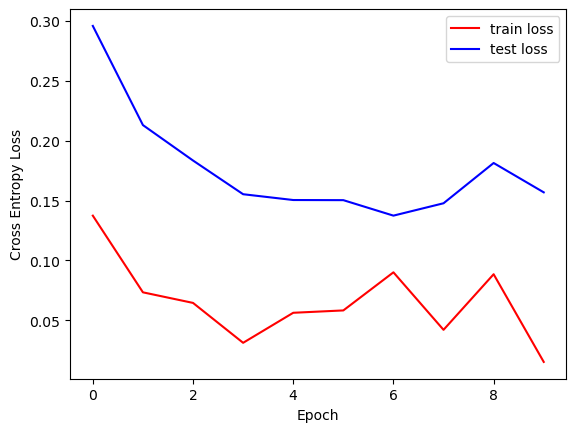

In [29]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend();

In [30]:
train_accuracies = [x/600 for x in train_correct_predictions]
test_accuracies = [x/100 for x in test_correct_predictions]

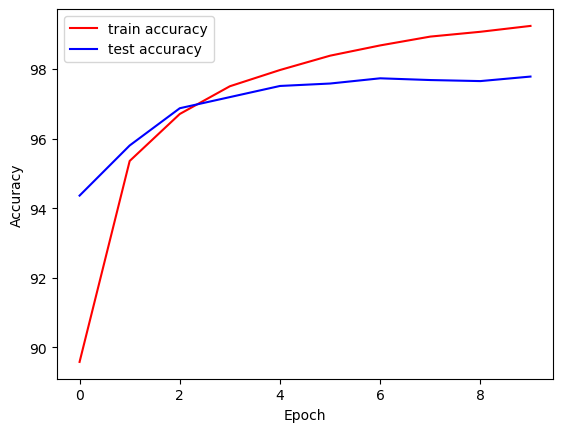

In [31]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

In [32]:
# Test the model on new UNSEEN data
test_data = DataLoader(dataset=mnist_test,batch_size=10000,shuffle=False)

In [33]:
type(test_data)

torch.utils.data.dataloader.DataLoader

In [34]:
with torch.no_grad():
    correct_predictions = 0

    for X_test, y_test in test_data:
        y_pred = model(X_test.view(len(X_test),-1))
        predicted = torch.max(y_pred,1)[1]
        correct_predictions += (predicted == y_test).sum()

In [35]:
100 * correct_predictions.item() / len(mnist_test)

97.78

In [37]:
confusion_matrix(predicted,y_test)

array([[ 972,    0,    4,    0,    1,    2,    5,    3,    3,    3],
       [   0, 1125,    3,    1,    0,    0,    3,    7,    0,    2],
       [   1,    3, 1004,    4,    1,    0,    2,   10,    3,    0],
       [   2,    2,    5,  987,    0,   13,    1,    1,    2,    3],
       [   0,    0,    2,    0,  961,    3,    2,    2,    3,    9],
       [   0,    0,    0,    6,    0,  862,    4,    0,    2,    2],
       [   1,    1,    2,    0,    6,    2,  940,    0,    1,    0],
       [   0,    0,    3,    3,    1,    1,    0,  986,    3,    0],
       [   3,    4,    9,    4,    2,    8,    1,    4,  954,    3],
       [   1,    0,    0,    5,   10,    1,    0,   15,    3,  987]],
      dtype=int64)

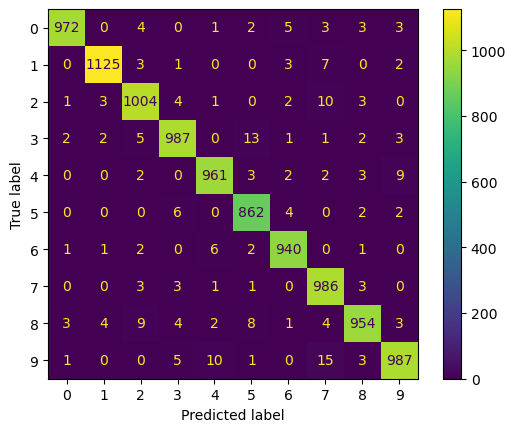

In [38]:
ConfusionMatrixDisplay.from_predictions(predicted,y_test)

In [39]:
print("Classification Report:")
print(classification_report(predicted,y_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       993
           1       0.99      0.99      0.99      1141
           2       0.97      0.98      0.97      1028
           3       0.98      0.97      0.97      1016
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.98       876
           6       0.98      0.99      0.98       953
           7       0.96      0.99      0.97       997
           8       0.98      0.96      0.97       992
           9       0.98      0.97      0.97      1022

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

